# Script to generate 3D subgraphs (x,y,z) 
### for input into Rhino/Grasshopper to 3D print a network

In [2]:
from multidimvis_main import *

In [14]:
G = nx.read_edgelist('input/ppi_elist.txt',data=False)

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

In [15]:
# random sample 
N = 150
rand_set = rd.sample(G.nodes(), N)

G_sub = nx.subgraph(G, rand_set)
G = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph

Number of nodes i.e. genes: 29
Number of edges: 31
Network density: 7.4%


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



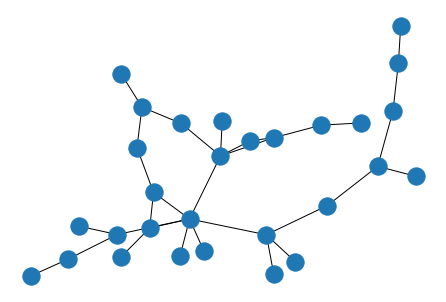

In [16]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

nx.draw(G)

### GENE ID to SYN (e.g. HOVERINFO for nodes)

In [5]:
entrez_syn = pd.read_csv('input/entrezid_syn.csv', index_col=0)
d_entrez_syn = dict(zip(entrez_syn.index,entrez_syn['db_synonym']))

d_gene2syn = {}
for k,v in d_entrez_syn.items():
    try:
        if k in G.nodes():
            d_gene2syn[k] = v
    except: 
           d_gene2syn['None'] = 'no entry'
            
d_genes_withsyn = {}
for g in G.nodes():
    for k,v in d_gene2syn.items():
        if g == k:
            d_genes_withsyn[g] = v
            
d_genes_nosyn = {}
for gene in G.nodes():
    if gene not in d_genes_withsyn.keys():
        d_genes_nosyn[gene] = 'no entry'
        
d_genes_all = {**d_genes_withsyn, **d_genes_nosyn}
d_genes_syn_sorted = {key:d_genes_all[key] for key in G.nodes()}

l_genes_syn=[]
for k,v in d_genes_syn_sorted.items():
    try:
        l_genes_syn.append(set(v.split('|')))
    except:
        l_genes_syn.append(v)
        
d_genes_syn_complete = {}
for i,v in enumerate(d_genes_syn_sorted.keys()):
    for idx,l in enumerate(l_genes_syn):
        if i==idx:
            d_genes_syn_complete[v] = l
            
l_features = list(zip(d_genes_syn_complete.keys(),d_genes_syn_complete.values()))

#### Markov: Random Walk with restart probability

In [6]:
%%time

A = nx.adjacency_matrix(G)
DM_adj = A.toarray()

CPU times: user 3.33 ms, sys: 130 µs, total: 3.46 ms
Wall time: 3.44 ms


In [7]:
%%time

# Restart probability
r = .8 # originally 0.8
alpha = 1.0 # indicating "randomness" 

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_df = pd.DataFrame(DM_m)
# DM_m_df.sum(axis=0)

DM_m_transposed = DM_m_df.T
DM_m_transposed.index = list(G.nodes())

metric = "correlation"
DM_m_new = pd.DataFrame(distance.squareform(distance.pdist(DM_m_transposed, metric)))

CPU times: user 5.82 ms, sys: 2.3 ms, total: 8.11 ms
Wall time: 3.08 ms


In [8]:
DM = DM_m_new.round(decimals = 2)

In [9]:
DM.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.00,1.06,1.01,1.05,1.05,1.05,0.74,1.05,1.06,1.05,...,1.06,1.06,1.05,1.03,1.06,1.05,1.05,1.06,1.06,1.05
1,1.06,0.00,1.06,1.06,1.05,1.05,1.06,1.06,1.00,1.06,...,1.00,1.00,1.06,1.05,1.00,1.04,1.06,1.00,1.06,1.05
2,1.01,1.06,0.00,1.06,1.05,1.05,1.04,1.06,1.06,1.05,...,1.06,1.06,1.05,1.01,1.06,1.05,1.06,1.06,1.06,1.05
3,1.05,1.06,1.06,0.00,1.06,1.05,1.05,1.05,1.06,1.05,...,1.06,1.06,1.03,1.06,1.06,1.06,0.79,1.06,1.02,1.06
4,1.05,1.05,1.05,1.06,0.00,1.05,1.05,1.05,1.05,1.05,...,1.05,1.05,1.05,1.04,1.05,0.91,1.05,1.05,1.06,1.02


### Feature matrix

In [12]:
feature_df = pd.read_csv('output_csv/Features_centralities_Dataframe_Yeast.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),feature_df['degs']))
d_clos = dict(zip(G.nodes(),feature_df['clos']))
d_betw = dict(zip(G.nodes(),feature_df['betw']))
d_eigen = dict(zip(G.nodes(),feature_df['eigen']))

feature_dict = feature_df.to_dict(orient='index')

In [ ]:
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}

l_features = [] 
for i in feature_dict_sorted.items():
    k = list(i)
    l_features.append(k)

In [ ]:
%%time

# PW euclidean metric 
DM_eucl = distance.squareform(distance.pdist(feature_df, 'euclidean'))

____________
# PRE-SETTINGS
____________

In [159]:
size3d = 10

edge_width = 5
opacity_nodes = 1
opacity_edges = 0.9

l_genes = rand_set
colour = 'red'

d_edge_col = color_edges_from_genelist(G, l_genes, colour)
edge_color = 3*list(d_edge_col.values())

____________
# LAYOUTS
____________


## PORTRAITS

In [160]:
prplxty3d = 50 # range: 5-50 / default = 30.#
density3d = 1.2 # default 12.
l_rate3d = 5000 # default 200.
steps3d = 1000 #min 250

metric = 'euclidean'

In [161]:
%%time
tsne_embed = embed_tsne_3D(DM, prplxty3d, density3d, l_rate3d, steps3d, metric)

CPU times: user 2.26 s, sys: 220 ms, total: 2.48 s
Wall time: 373 ms


In [162]:
posG = get_posG_3D(G, tsne_embed)

In [163]:
tsne_edges = get_trace_edges_from_genelist(list(d_edge_col.keys()), posG, edge_color)
tsne_nodes = get_trace_nodes(posG, l_features, colour, size3d)

tsne_data = [tsne_edges, tsne_nodes]

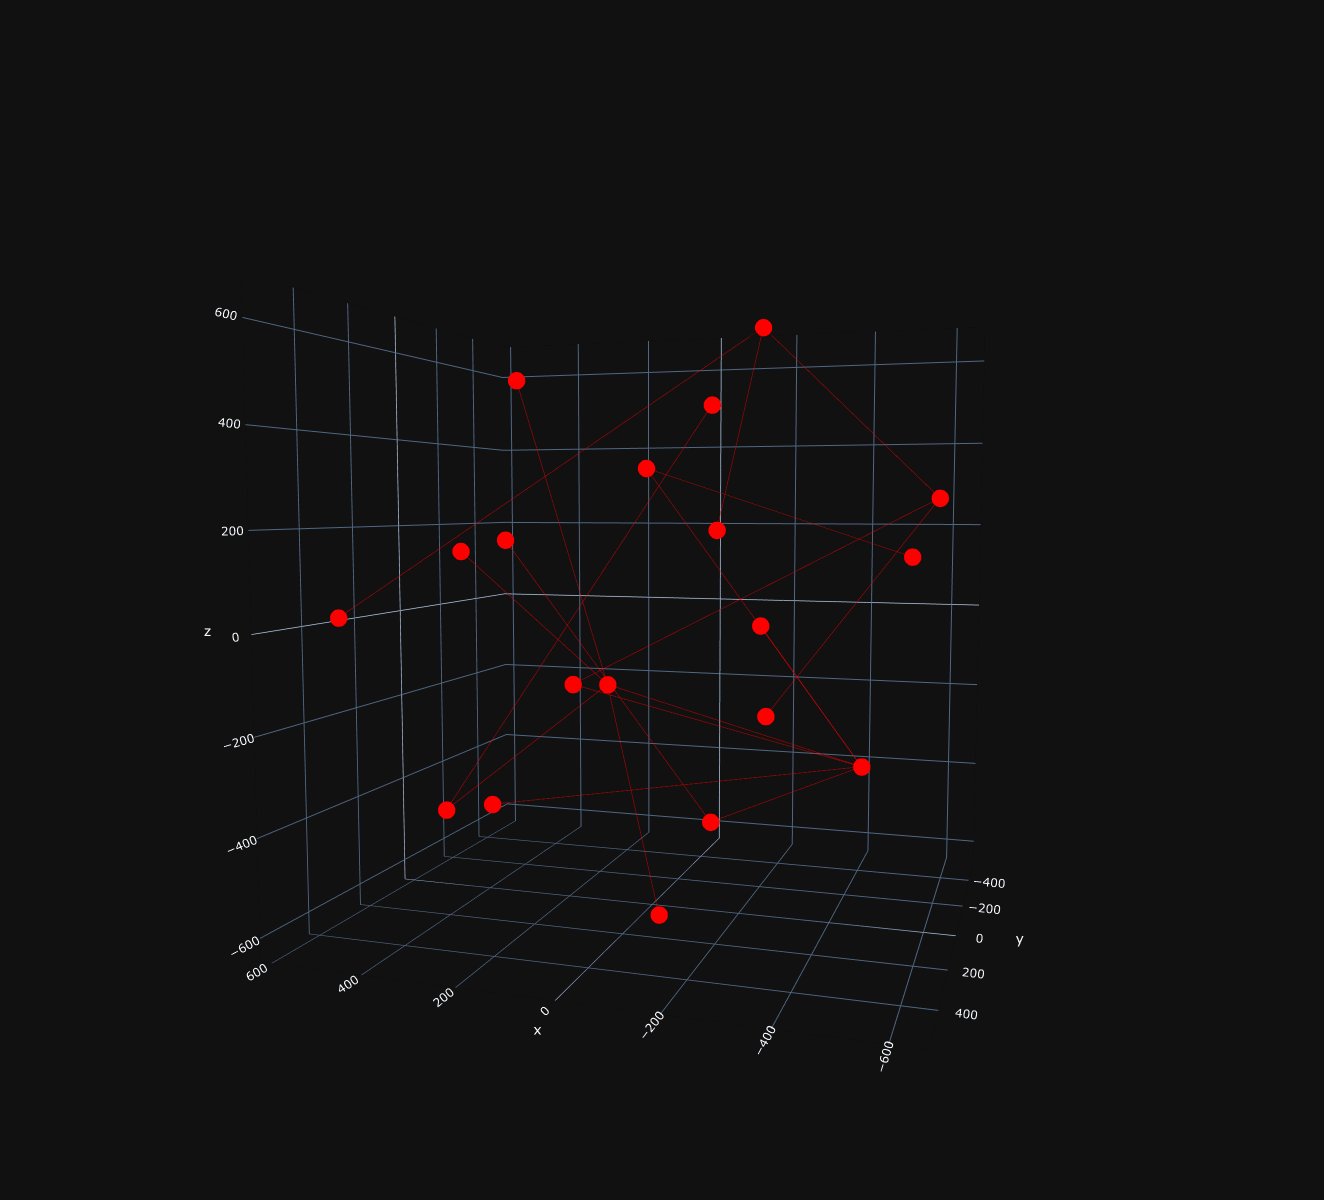

In [164]:
fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200)
py.iplot(fig)

In [165]:
posG_export = pd.DataFrame(posG).T
posG_export.to_csv(r'output_csv/3Dprint_subgraph_test01.csv', index = True)

## SPHERE

In [167]:
metric = 'euclidean'

In [168]:
%%time 
umap_sphere = embed_umap_sphere(G, DM, metric)

CPU times: user 2.09 s, sys: 89.3 ms, total: 2.18 s
Wall time: 2.07 s


In [169]:
%%time
umap_sphere_trace_edges = get_trace_edges(G, umap_sphere, edge_color)
umap_sphere_trace_nodes = get_trace_umap_sphere(umap_sphere, l_features, colour, size3d)
umap_sphere_data = [umap_sphere_trace_edges, umap_sphere_trace_nodes]

CPU times: user 13.4 ms, sys: 467 µs, total: 13.9 ms
Wall time: 13.5 ms


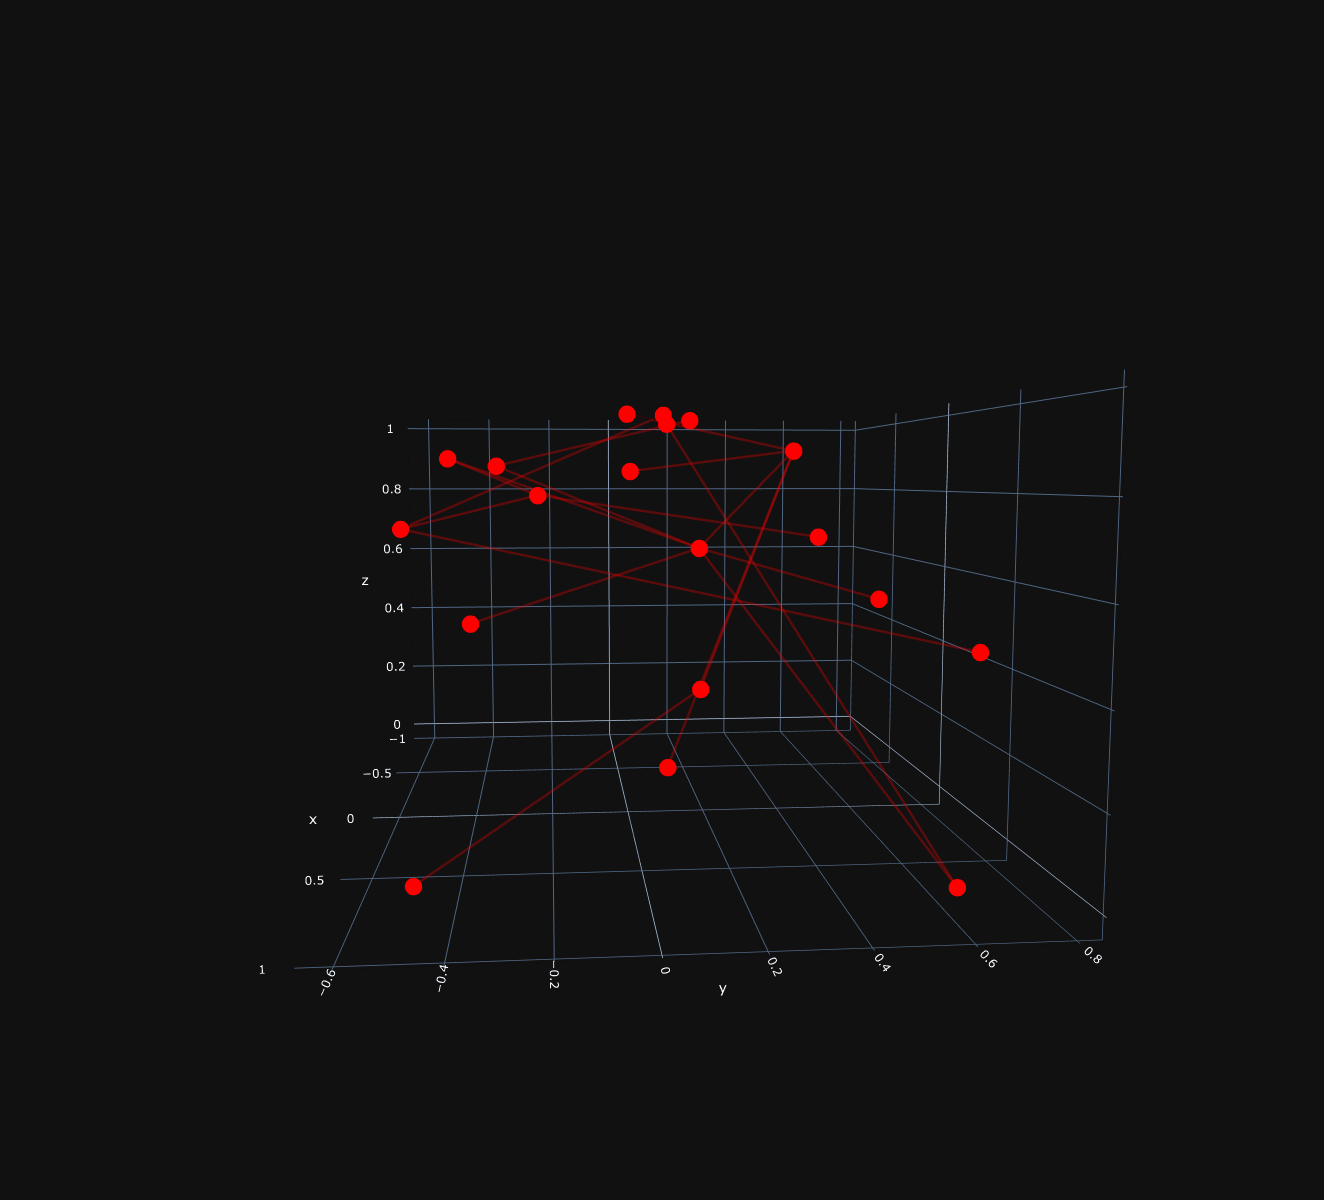

In [170]:
fig = pgo.Figure()
for i in umap_sphere_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200)
py.iplot(fig)